# Russian Twitter Influence on the United States in 2015-2018

#### Team Name: 
Team Good Luck in Theater

#### Team Members:
- Yimeng Yang (A13643478)
- Tony Huang (A--)
- Ricky Martin (A--)
- Raya Kavosh (A--)
- Waylon Chang (A--)
- Jarek Lu (A14106974)

## 1. Introduction

### Overview

- Russian bots were active on Twitter conducting misinformation campaigns starting at the very latest when the United States 2016 Elections were in session.
- In preparation for upcoming elections, Twitter released an archive of the Tweets used in the campaigns.
- Seeing this data, we were curious on how (at a subject level) Russia conducted this campaign.
- Using various statistical techniques, we found that there were no strong high-level correlations in account activity, but instead smaller, weaker correlations at lower levels, *which may be how Russia hid their campaign.*

### Background

Since 2015, it became evident to United States security officials that Russia had engaged in an information manipulation campaign to influence, amongst other things, the United States Federal and State elections. One way they achieved this was through the usage of a coordinated bot network on Twitter to influence potential voters through messages. 

After the ordeal, a large portion of the tweets used in the influence campaign was set up and stored for independent research. Some of this research includes attempting to see if there are designs that can categorize Tweet content into [discrete types](http://pwarren.people.clemson.edu/Linvill_Warren_TrollFactory.pdf), or to make other somewhat [surface-level findings](https://www.vox.com/2018/10/19/17990946/twitter-russian-trolls-bots-election-tampering), but not focusing on how specifically Russia conducted a misinformation campaign globally and domestically. 



### Research Question

We are interested in seeing how Russia coordinated an influence campaign in the United States (English Tweets). More specifically, **we are interested in determining if there was some kind of correlation of account details/activity with respect to subject terms embedded in tweets**, such as tweets that were about "Hillary Clinton". To do so, we looked for correlations between top subjects in tweets, and then dove deeper into sub-sets of the Tweets classified by further filters, such as accounts from Russia that were either "Left" or "Right" leaning. Finally, using this data, we also experimented with building a NLP model that can classify tweets as being leftist or rightist.

### Hypothesis

We predict that more popular accounts will use a higher frequency of key subject terms, such as "Trump" and "Hilary" in their tweets, as well as send out tweets at a higher frequency. 

With respect to the overall timeline, we expect that we will find subject popularity heavily dependent on time. For example, "Trump" may be a popular topic overall, but the names of individuals involved in the large amount of domestic mass shootings in 2018 may spike during their overall event time ranges.

We think that we can use number of followers or updates to measure influence of a tweet. Although there can be limitation to the accurcy of this measurement as there can be a lot of fake followers and updates. We predict that there is some correlation between followers and the account_type for tweets. We predict that there will be about the same distribution for left and right as the tweet bots can be trying to polarize the public opinions.

## 2. Dataset(s)

The dataset we used can be found [https://github.com/fivethirtyeight/russian-troll-tweets](here).
It contains 3 million russian troll tweets, where each row is a tweet.

The files have the following columns:

Header | Definition
---|---------
`external_author_id` | An author account ID from Twitter 
`author` | The handle sending the tweet
`content` | The text of the tweet
`region` | A region classification, as [determined by Social Studio](https://help.salesforce.com/articleView?id=000199367&type=1)
`language` | The language of the tweet
`publish_date` | The date and time the tweet was sent
`harvested_date` | The date and time the tweet was collected by Social Studio
`following` | The number of accounts the handle was following at the time of the tweet
`followers` | The number of followers the handle had at the time of the tweet
`updates` | The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes
`post_type` | Indicates if the tweet was a retweet or a quote-tweet
`account_type` | Specific account theme, as coded by Linvill and Warren
`retweet` | A binary indicator of whether or not the tweet is a retweet
`account_category` | General account theme, as coded by Linvill and Warren
`new_june_2018` | A binary indicator of whether the handle was newly listed in June 2018
`alt_external_id` | Reconstruction of author account ID from Twitter, derived from `article_url` variable and the first list provided to Congress
`tweet_id` | Unique id assigned by twitter to each status update, derived from `article_url`
`article_url` | Link to original tweet. Now redirects to "Account Suspended" page
`tco1_step1` | First redirect for the first http(s)://t.co/ link in a tweet, if it exists
`tco2_step1` | First redirect for the second http(s)://t.co/ link in a tweet, if it exists
`tco3_step1` | First redirect for the third http(s)://t.co/ link in a tweet, if it exists

### Imports and Loading Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import collections
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns, numpy as np
import patsy

In [2]:
import glob
file_paths = glob.glob('./data/*')
tweet_type_per_file={}
frames = []
for i, p in enumerate(file_paths):
    # If we want to read fewer files, uncomment this line
    #if i > 4:
    #    break
    tweets = pd.read_csv(p)
    frames.append(tweets)
big_frame = pd.concat(frames)

/home/glacierpika/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/glacierpika/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/glacierpika/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,15,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Store the big_frame object into a tweets object, so we can always reference big_frame without reloading everything.
tweets = big_frame
tweets.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,...,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,...,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,...,Right,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,...,Right,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,...,Right,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN


## 3. Data Analysis

### Data Cleaning 
This is general data cleaning, more specific data cleaning is included before each case below

#### I. Filter out only English tweets and tweets in United States
For the purposes of this study, we are only interested in English-language tweets that occured in the "United States" region.

In [4]:
english_tweets = tweets[(tweets['language']=='English') & (tweets['region']=="United States")]

#### II. Lowercase all content
Next, we want to reduce all the content of the Tweets into lower-case. We initially observed that capitalization of topics (when used in similar contexts) was inconsistent.

In [5]:
def clean_data(tweets):
    """ Lowercase all contents
    """
    tweets['content'] = tweets['content'].str.lower()

In [6]:
clean_data(english_tweets)

/home/glacierpika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### III. Provide a visualization of the data to help improve comprehension

##### Helper functions for visualization

In [7]:
def plot_account(tweets):
    """ Plot different type of account activity over time
    """
    tweets['Right_count'] = tweets.apply(lambda x: 1 if x['account_type'] == 'Right' else 0, axis=1)
    tweets['Left_count'] = tweets.apply(lambda x: 1 if x['account_type'] == 'Left' else 0, axis=1)
    tweets['RightTroll_count'] = tweets.apply(lambda x: 1 if x['account_category'] == 'RightTroll' else 0, axis=1)
    tweets['LeftTroll_count'] = tweets.apply(lambda x: 1 if x['account_category'] == 'LeftTroll' else 0, axis=1)
    tweets[['Right_count']].resample('M').sum().plot()  
    tweets[['Left_count']].resample('M').sum().plot()
    tweets[['RightTroll_count']].resample('M').sum().plot()
    tweets[['LeftTroll_count']].resample('M').sum().plot()

##### Plot tweet frequencies over time

In [8]:
english_tweets.index = pd.to_datetime(english_tweets["publish_date"])

/home/glacierpika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Resample by Day')

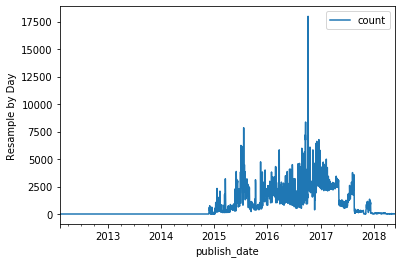

In [9]:
english_tweets['count'] = [1] * len(english_tweets)
english_tweets[['count']].resample('D').sum().plot().set_ylabel('Resample by Day')

Text(0, 0.5, 'Resample by Week')

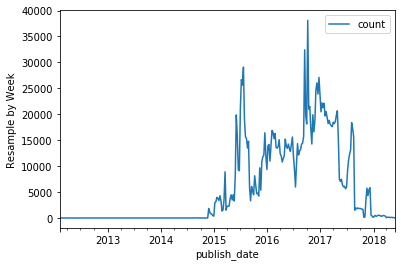

In [10]:
english_tweets[['count']].resample('W').sum().plot().set_ylabel('Resample by Week')

Text(0, 0.5, 'Resample by Month')

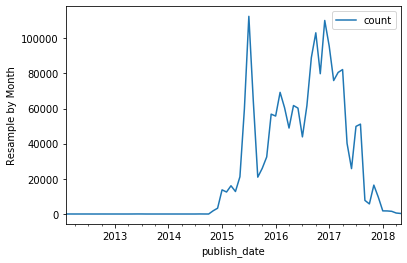

In [11]:
english_tweets[['count']].resample('M').sum().plot().set_ylabel('Resample by Month')

##### Plot account_type activity over time

/home/glacierpika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/glacierpika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/glacierpika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

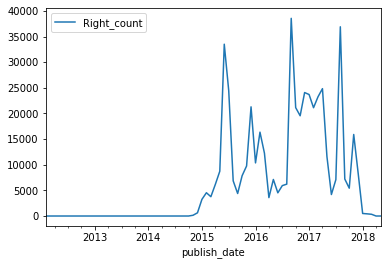

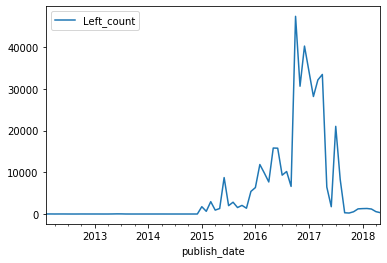

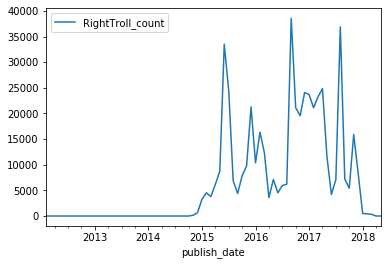

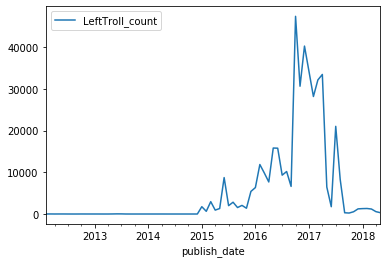

In [12]:
plot_account(english_tweets)

#### IV. Only use tweets from 2016.6 to 2017.5

From our visualizations, we observed that the bulk of bot activity whose accounts were classified as either "Left" or "Right" occured between 2016.6 and 2017.5. Therefore, we will narrow down our data to that time period (we are only interested in Left/Right account, see next section).

In [13]:
tweets_2016_2017 = english_tweets[
    (
        (english_tweets.index.year == 2016) & (english_tweets.index.month >= 6)
    ) | (
        (english_tweets.index.year == 2017) & (english_tweets.index.month <= 5)
    )]

#### V. Focus on account_type Left and Right. 
We are only interested in Left/Right tweets, filter out any Tweets which accounts are not "Left" or "Right"

In [14]:
tweets_2016_2017 = tweets_2016_2017[(tweets_2016_2017['account_type']=='Left') | (tweets_2016_2017['account_type']=='Right')]

### Data Visualizations

#### Helper functions for visualization

In [15]:
def word_freq(tweets):
    """ Calculate word frequency for each word in the tweet contents
    """
    content_loc= tweets.columns.get_loc("content")
    words = []
    for i in range(len(tweets)):
        c = tweets.iloc[i, content_loc]
        if isinstance(c, str):
            words.append(c.lower().split(" "))
    words = list(itertools.chain(*words))
    counts= collections.Counter(words)
    return counts

In [16]:
# Some predefined filler_words that we want to filter out
filler_words = [
    '', 'to', 'in', 'the', 'of', 'for', 'your', 'my', 'his', 'all',
    'a','on','and','is','at','with','after','you','from','as','i',
    'by','be','says','are','this','that','not','over','it','will',
    'who','was','about','have','up','we','more','but','just','rt',
    'get', 'out', '-','&amp;','new', '&', 'they', 'so', 'if', 'an',
    'has', 'now', 'our', 'like', 'don\'t','i\'m', 'when', 'how',
    'their','he', 'me', 'no', 'has', 'it\'s', 'or', 'do', 'via',
    'why', 'want', 'us', 'her', 'she', 'can', 'need', 'because',
    'only', 'one', 'should', 'see', 'being', 'him', 'would', 'were',
    'those', 'during', 'know', 'been', 'some', 'day', 'then', 'than',
    'into', 'can\'t', 'still', 'there', 'years', 'got', 'say', 'you\'re',
    'them', 'most', 'it.', 'these', 'this.', 'never', 'what', 'found',
    'let', 'much', 'many',':', 'here', '2', 'may']

In [17]:
def plot_word_freq(tweets, year_start, year_end, month_start, month_end):
    num_month = 13 - month_start + month_end + (year_end - year_start - 1) * 12
    fig, ax = plt.subplots(num_month,1,figsize=(8, 32))
    count = 0
    
    for year in range(year_start,year_end+1):
        if year_start == year_end:
            month_range = range(month_start, month_end+1)
        elif year == year_start:
            month_range = range(month_start, 13)
        elif year == year_end:
            month_range = range(1, month_end+1)
        else:
            month_range = range(1,13)
            
        for month in month_range:
            counter = word_freq(
                tweets[
                    (tweets.index.year == year) &
                    (tweets.index.month == month)
                ]
            )
            for w in filler_words:
                del counter[w]
            freqs = counter.most_common(10)

            labels, values = zip(*freqs)

            indexes = np.arange(len(labels))
            width = 1

            ax[count].bar(indexes, values, width)
            rects = ax[count].patches
            ax[count].set_xlabel('top_words')
            ax[count].set_ylabel("{}-{}".format(year, month))
            
            for rect, label in zip(rects, labels):
                height = rect.get_height()
                ax[count].text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                ha='center', va='bottom', rotation=45)
            count += 1

In [18]:
def word_freq_df(tweets, year_start, year_end, month_start, month_end, num=100):    
    d={}
    num_month = 13 - month_start + month_end + (year_end - year_start - 1) * 12 
    for year in range(year_start,year_end+1):
        if year_start == year_end:
            month_range = range(month_start, month_end+1)
        elif year == year_start:
            month_range = range(month_start, 13)
        elif year == year_end:
            month_range = range(1, month_end+1)
        else:
            month_range = range(1,13)
            
        for month in month_range:
            counter = word_freq(
                tweets[
                    (tweets.index.year == year) &
                    (tweets.index.month == month)
                ]
            )
            for w in filler_words:
                del counter[w]
            freqs = counter.most_common(num)
            datetime = "{}-{}".format(year, month)
            d[datetime] = freqs
    return pd.DataFrame.from_dict(d)

In [19]:
def plot_word_freq_by_word(tweets, word_count=10):
    counter = word_freq(
                tweets
            )
    for w in filler_words:
        del counter[w]
    freqs = counter.most_common(word_count)
    
    for w in freqs:
        w = w[0]
        col_name = '{}_count'.format(w)
        print(w)
        tweets[col_name] = tweets.apply(lambda x: 1 if x['content'].find(w) >= 0 else 0, axis=1)
        tweets[[col_name]].resample('M').sum().plot()  

#### Word frequency analysis
We will visualize most popular words for our interested dataset for Left or Right accounts only to see what each account type was trying to promote.

##### I. Find top words for the entire dataset

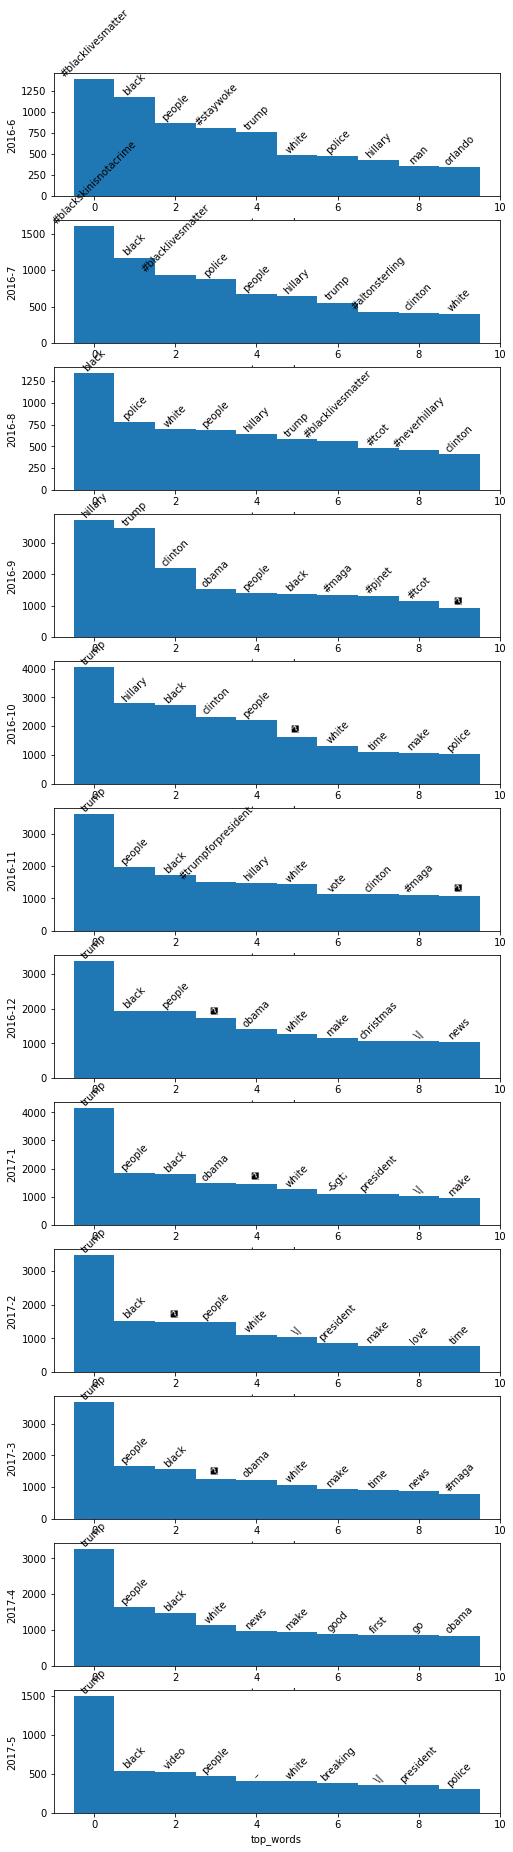

In [20]:
plot_word_freq(tweets_2016_2017, 2016, 2017, 6, 5)

- At a high level, most popular topics are pretty consistent with topics in America that tended to be most divided upon, such as Trump, Black Lives Matter, Hilary Clinton, police, and the US Presidency.

In [21]:
freq_table_all = word_freq_df(tweets_2016_2017, 2016, 2017, 6, 5)
freq_table_all

,2016-6,2016-7,2016-8,2016-9,2016-10,2016-11,2016-12,2017-1,2017-2,2017-3,2017-4,2017-5
0,"(#blacklivesmatter, 1393)","(#blackskinisnotacrime, 1604)","(black, 1342)","(hillary, 3729)","(trump, 4045)","(trump, 3602)","(trump, 3370)","(trump, 4143)","(trump, 3475)","(trump, 3678)","(trump, 3253)","(trump, 1492)"
1,"(black, 1177)","(black, 1171)","(police, 776)","(trump, 3492)","(hillary, 2787)","(people, 1970)","(black, 1941)","(people, 1836)","(black, 1528)","(people, 1683)","(people, 1634)","(black, 537)"
2,"(people, 866)","(#blacklivesmatter, 939)","(white, 696)","(clinton, 2188)","(black, 2723)","(black, 1723)","(people, 1937)","(black, 1807)","(�, 1489)","(black, 1569)","(black, 1470)","(video, 526)"
3,"(#staywoke, 813)","(police, 880)","(people, 691)","(obama, 1516)","(clinton, 2331)","(#trumpforpresident, 1523)","(�, 1722)","(obama, 1477)","(people, 1477)","(�, 1261)","(white, 1142)","(people, 467)"
4,"(trump, 759)","(people, 674)","(hillary, 641)","(people, 1404)","(people, 2203)","(hillary, 1479)","(obama, 1414)","(�, 1448)","(white, 1108)","(obama, 1240)","(news, 971)","(–, 412)"
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(4, 136)","(president, 117)","(hate, 113)","(down, 325)","(does, 478)","(win, 375)","(must, 443)","(same, 395)","(didn't, 338)","(work, 403)","(america, 385)","(keep, 112)"
96,"(#brexit, 135)","(#batonrouge, 117)","(please, 113)","(last, 324)","(doesn't, 478)","(free, 375)","(1, 442)","(happy, 394)","(he's, 338)","(#soundcloud, 388)","(where, 384)","(election, 112)"
97,"(death, 135)","(look, 116)","(history, 113)","(u.s., 323)","(voting, 477)","(where, 374)","(things, 442)","(didn't, 394)","(help, 337)","(health, 388)","(always, 384)","(war, 111)"
98,"(campaign, 134)","(believe, 116)","(kill, 112)","(woman, 322)","(money, 475)","(other, 371)","(big, 441)","(john, 393)","(please, 337)","(come, 385)","(woman, 383)","(former, 111)"


##### II. Find what Leftist Russian accounts were promoting
account_type: Left

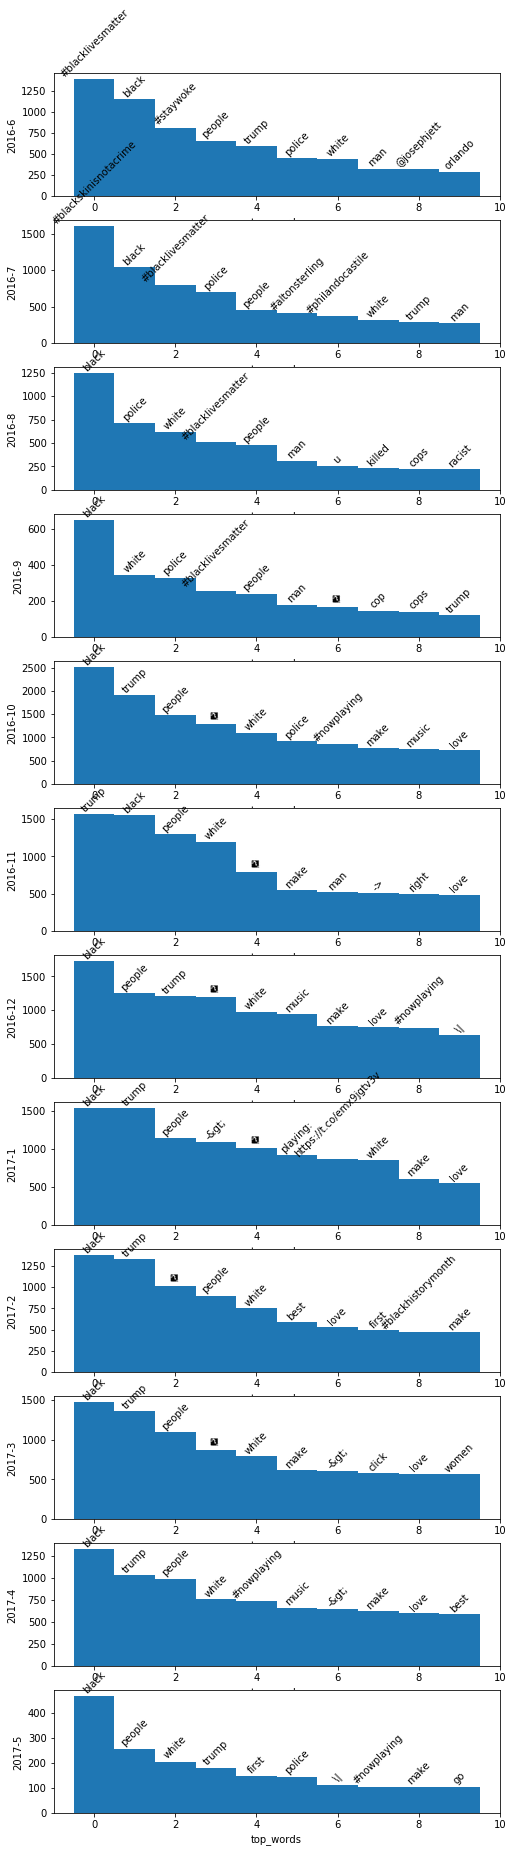

In [22]:
left = tweets_2016_2017[tweets_2016_2017['account_type'] == 'Left']
plot_word_freq(left, 2016, 2017, 6, 5)

- We can briefly observe that Leftist occused focused heavily on a smaller set of topics, such as Trump, racial tensions (black/white), police, and the people - topics that were popular in politically left-leaning conversations and outlets.

In [25]:
freq_table = word_freq_df(left, 2016, 2017, 6, 5)

In [26]:
freq_table

,2016-6,2016-7,2016-8,2016-9,2016-10,2016-11,2016-12,2017-1,2017-2,2017-3,2017-4,2017-5
0,"(#blacklivesmatter, 1389)","(#blackskinisnotacrime, 1604)","(black, 1244)","(black, 649)","(black, 2512)","(trump, 1564)","(black, 1724)","(black, 1533)","(black, 1377)","(black, 1474)","(black, 1322)","(black, 468)"
1,"(black, 1148)","(black, 1042)","(police, 709)","(white, 346)","(trump, 1913)","(black, 1549)","(people, 1258)","(trump, 1531)","(trump, 1334)","(trump, 1361)","(trump, 1026)","(people, 255)"
2,"(#staywoke, 813)","(#blacklivesmatter, 801)","(white, 619)","(police, 327)","(people, 1490)","(people, 1302)","(trump, 1209)","(people, 1140)","(�, 1015)","(people, 1102)","(people, 989)","(white, 205)"
3,"(people, 658)","(police, 695)","(#blacklivesmatter, 506)","(#blacklivesmatter, 258)","(�, 1284)","(white, 1193)","(�, 1192)","(-&gt;, 1089)","(people, 901)","(�, 875)","(white, 754)","(trump, 181)"
4,"(trump, 597)","(people, 446)","(people, 479)","(people, 240)","(white, 1103)","(�, 787)","(white, 975)","(�, 1008)","(white, 749)","(white, 792)","(#nowplaying, 738)","(first, 148)"
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(live, 107)","(\|, 70)","(call, 76)","(am, 46)","(shit, 328)","(won't, 218)","(woman, 266)","(support, 229)","(before, 196)","(things, 217)","(another, 218)","(song, 44)"
96,"(4, 107)","(racism, 70)","(simone, 76)","(own, 46)","(same, 325)","(win, 217)","(donald, 265)","(shit, 228)","(help, 190)","(next, 217)","(use, 217)","(high, 44)"
97,"(twitter, 105)","(person, 69)","(read, 75)","(#prisonstrike, 46)","(help, 324)","(shit, 217)","(support, 265)","(american, 228)","(please, 190)","(where, 217)","(own, 217)","(tell, 44)"
98,"(off, 104)","(help, 69)","(rights, 75)","(explain, 45)","(put, 322)","(1, 216)","(give, 264)","(fuck, 228)","(didn't, 189)","(two, 215)","(hit, 214)","(family, 44)"


##### III. Find what Rightist Russian accounts were promoting
account_type: Right

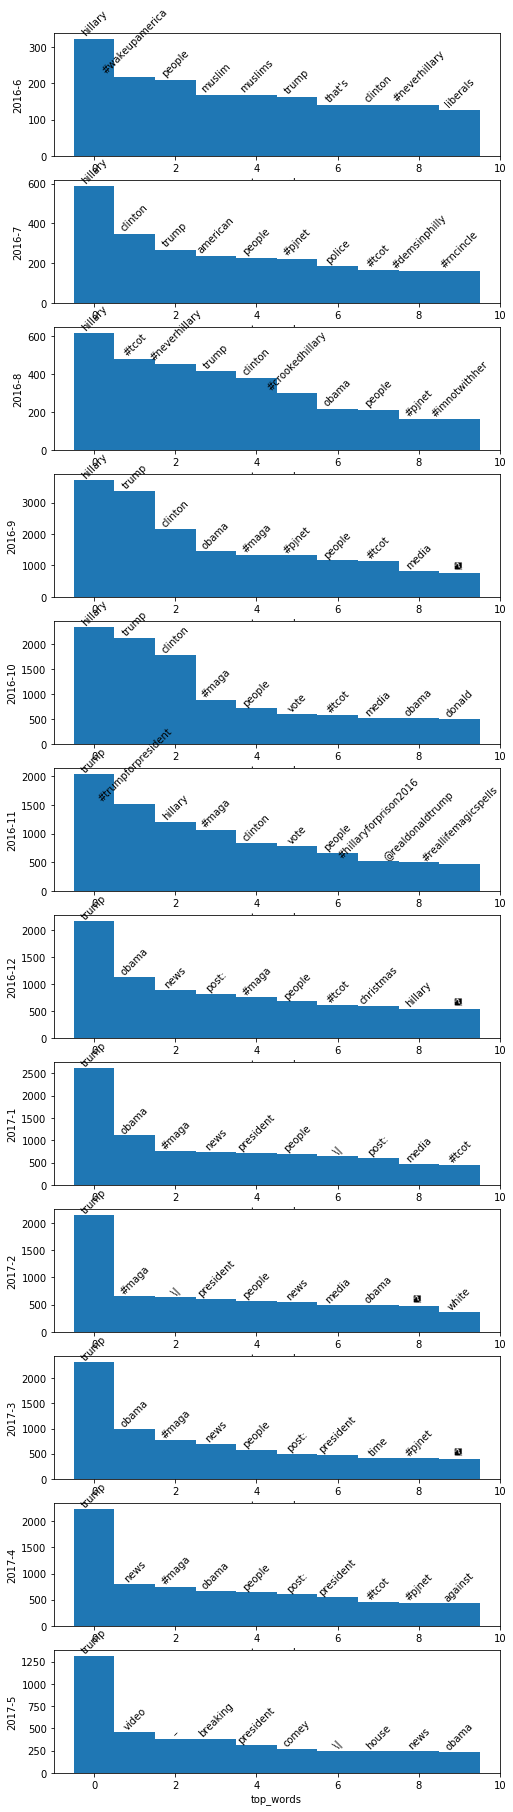

In [27]:
right = tweets_2016_2017[tweets_2016_2017['account_type'] == 'Right']
plot_word_freq(right, 2016, 2017, 6, 5)

Meanwhile, we observed that right-leaning Russian accounts seemed to be more engaged in talknig about Trump, Obama, Clinton (emails), #maga. There were also references to "fake" (fake news), and James Comey (widely considered a traitor by the Political Right).

In [28]:
freq_table_right = word_freq_df(right, 2016, 2017, 6, 5)

In [29]:
freq_table_right

,2016-6,2016-7,2016-8,2016-9,2016-10,2016-11,2016-12,2017-1,2017-2,2017-3,2017-4,2017-5
0,"(hillary, 321)","(hillary, 587)","(hillary, 615)","(hillary, 3713)","(hillary, 2340)","(trump, 2038)","(trump, 2161)","(trump, 2612)","(trump, 2141)","(trump, 2317)","(trump, 2227)","(trump, 1311)"
1,"(#wakeupamerica, 216)","(clinton, 346)","(#tcot, 479)","(trump, 3372)","(trump, 2132)","(#trumpforpresident, 1523)","(obama, 1126)","(obama, 1106)","(#maga, 656)","(obama, 987)","(news, 798)","(video, 459)"
2,"(people, 208)","(trump, 267)","(#neverhillary, 455)","(clinton, 2161)","(clinton, 1774)","(hillary, 1209)","(news, 883)","(#maga, 748)","(\|, 632)","(#maga, 767)","(#maga, 742)","(–, 382)"
3,"(muslim, 167)","(american, 236)","(trump, 415)","(obama, 1475)","(#maga, 890)","(#maga, 1069)","(post:, 819)","(news, 730)","(president, 603)","(news, 692)","(obama, 668)","(breaking, 379)"
4,"(muslims, 167)","(people, 228)","(clinton, 379)","(#maga, 1347)","(people, 713)","(clinton, 837)","(#maga, 751)","(president, 723)","(people, 576)","(people, 581)","(people, 645)","(president, 309)"
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(he's, 38)","(its, 50)","(share, 54)","(u.s., 294)","(#debatenight, 171)","(voters, 149)","(u, 176)","(keep, 179)","(mt, 154)","(please, 176)","(big, 184)","(climate, 79)"
96,"(religion, 37)","(@realdonaldtrump, 50)","(very, 54)","(nyc, 293)","(last, 171)","(real, 149)","(does, 175)","(doesn't, 178)","(black, 151)","(congress, 175)","(way, 184)","(pictures, 79)"
97,"(also, 37)","(join, 50)","(go, 53)","(other, 290)","(#wikileaks, 171)","(doesn't, 149)","(cia, 174)","(support, 175)","(really, 151)","(that's, 174)","(calls, 182)","(made, 78)"
98,"(happy, 36)","(another, 50)","(law, 53)","(attack, 290)","(love, 171)","(americans, 147)","(country, 174)","(u, 175)","(look, 150)","(police, 173)","(other, 181)","(lol, 78)"


### Data Analysis

Before we begin, we need to define some helper functions that will allow us to run analysis better.

In [30]:
def get_high_outliers_lr(df, x, y):
    """ Get outliers that is greater than (mean + 2 * standard deviation)
    This is used in account_type analysis
    """
    left = df[df[x]=='Left']
    right = df[df[x]=='Right']
    left = get_high_outliers(left, y)
    right = get_high_outliers(right, y)
    return pd.concat([left,right])

def get_high_outliers(df, y):
    m = np.mean(df[y])
    s = np.std(df[y])
    return df[(df[y] > m + 2*s)]

In [31]:
def filter_outliers_lr(df, x, y):
    """ Filter outliers for account_type vs y analysis
    """
    left = df[df[x]=='Left']
    right = df[df[x]=='Right']
    left = filter_outliers(left, y)
    right = filter_outliers(right, y)
    return pd.concat([left,right])

def filter_outliers_tweet_type(df, y):
    """ Filter outliers for tweet_type vs y analysis
    """
    retweet = df[df['post_type']=='retweet']
    quote = df[df['post_type']=='quote_tweet']
    new_content = df[df['post_type']=='new']
    retweet = filter_outliers(retweet, y)
    quote = filter_outliers(quote, y)
    new_content = filter_outliers(new_content, y)
    return pd.concat([retweet, quote, new_content])

def filter_outliers(df, y):
    """ Filter out outliers that is less than (mean - 2 * standard deviation) 
    or greater than (mean + 2 * standard deviation) or equal to 0
    """
    m = np.mean(df[y])
    s = np.std(df[y])
    return df[(df[y] < m + 2*s) & (df[y] > m - 2*s) & (df[y] != 0)]
    

In [32]:
def boxplot_withnum(df, x, y):
    """ Plot boxplot with numbers of samples within the box labelled
    """
    ax = sns.boxplot(x=x, y=y, data=df,showfliers=False)

    # Calculate number of obs per group & median to position labels
    medians = df.groupby([x])[y].median().values
    nobs = df[x].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    print(nobs)
    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 0.03, nobs[tick], horizontalalignment='center', size='x-small', color='w', weight='semibold')

In [33]:
def oneway_anova(df, x, y):
    """ Calculate one way Anova for df, x is discrete and y is continuous
    """
    mod = ols('{} ~ {}'.format(y,x),data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    print(aov_table)

#### Analyze Correlation between followers and account_type (specifically Left or Right)

To begin, we want to determine whether or not there was a correlation between the number of followers the bot accounts tended to have and what their political type leaning was. First, we extracted just tweets in our time range that meet the criteria, and then obtained the followers and account_types of all the accounts of the tweets within our range.

In [34]:
left_right = tweets_2016_2017[(tweets_2016_2017['account_type']=='Left') | (tweets_2016_2017['account_type']=='Right')]
account_type_followers = left_right[['followers','account_type']]
account_type_followers.head()

,followers,account_type
publish_date,,
2017-01-23 22:36:00,1,Right
2017-01-23 22:37:00,1,Right
2017-01-23 22:40:00,1,Right
2016-10-12 11:41:00,4691,Left
2016-10-12 11:41:00,4690,Left


Having this data, we plotted the findings into a boxplot. This allows us to represent where the majority of accounts lay (by quartile), and also see what kind of outliers there may be.

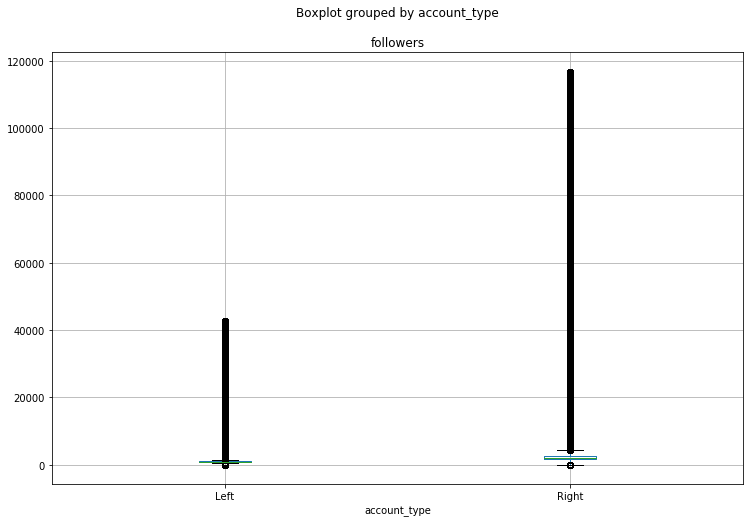

In [35]:
account_type_followers.boxplot('followers', by='account_type', figsize=(12, 8))

We can observe that most accounts (understandably) didn't have many followers. Regardless of account type, most followers were clustered at a very low amount. However, there appear to be huge outliers in both groups, where some accounts on the left had nearly 60,000 followers, and on the right, even over 140,000 followers. This already suggests that there isn't a strong (if even weak) correlation between account_type and number of followers, but it does show that Russia's right-leaning accounts had more cases of extreme outliers (which is a success for them).

['n: 294376', 'n: 224462']


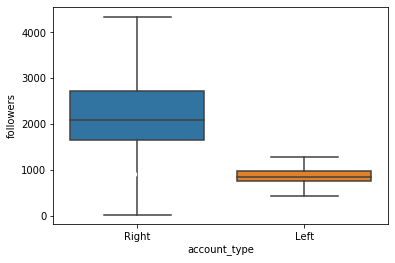

In [36]:
# Plot boxplot
boxplot_withnum(account_type_followers,x='account_type',y='followers')

To see if there is a statistically significant difference between the two groups, we ran a one-way ANOVA test to see if the results between groups are significant. As observed below, they are not.

In [37]:
oneway_anova(account_type_followers, 'account_type', 'followers')

                    sum_sq        df             F  PR(>F)
account_type  3.995826e+12       1.0  29246.316345     0.0
Residual      7.088682e+13  518836.0           NaN     NaN


Even if the data above showed a lack of correlation, we did observe extreme outliers in both groups. In an influence campaign, we surmised that even a low amount of extreme outliers could be considered a success for Russian groups - as long as the few accounts that went viral passed on their message.

Thus, we want to take a closer look at the outliers which had followers greater than the mean + 2x the standard deviation of followers. We will, once again, plot this on a boxplot:

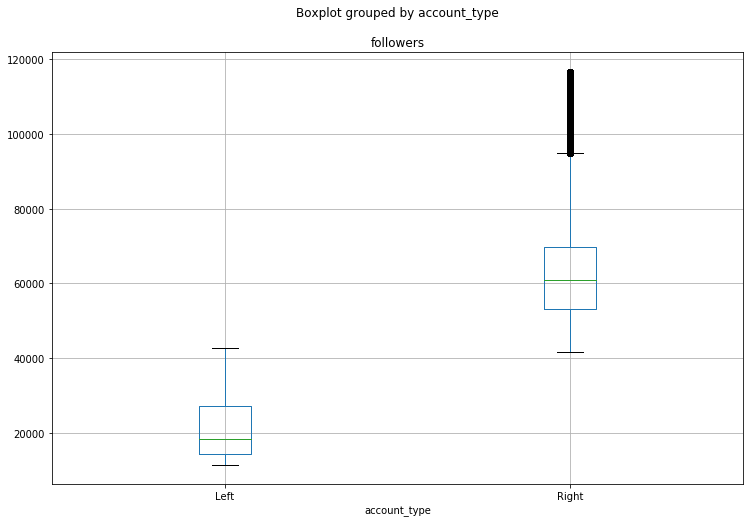

In [39]:
account_type_followers_high = get_high_outliers_lr(account_type_followers, 'account_type', 'followers')
account_type_followers_high.boxplot('followers', by='account_type', figsize=(12, 8))

Perhaps a little more interesting, was that we can observe outlier accounts in Leftist Russian accounts tended to have around 30,000 followers, while right-leaning accounts had around 45,000 (a relatively small amount more). However, the upper quartiles in the right account were still 3-5x greater than leftist accounts. 

We can find somewhat of a minor correlation from this with respect to account type - as mentioned above, outlier accounts that went viral did generally have a "range" they fell into.

['n: 13993', 'n: 11907']


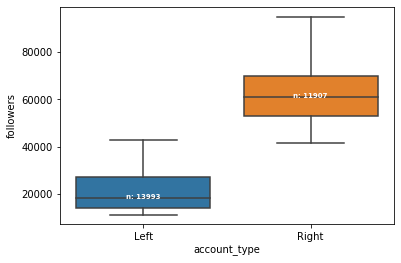

In [40]:
boxplot_withnum(account_type_followers_high,x='account_type',y='followers')

In [41]:
oneway_anova(account_type_followers_high, 'account_type', 'followers')

                    sum_sq       df             F  PR(>F)
account_type  1.253167e+13      1.0  58379.938772     0.0
Residual      5.559190e+12  25898.0           NaN     NaN


We also compared these two groups with a one-way ANOVA test. The results of the test suggest there is a statistically significant difference in the **outlier** groups, meaning at least for outliers, right-leaning account types tended to have more followers.

#### Analyze correlation between followers and account_type with outliers filtered

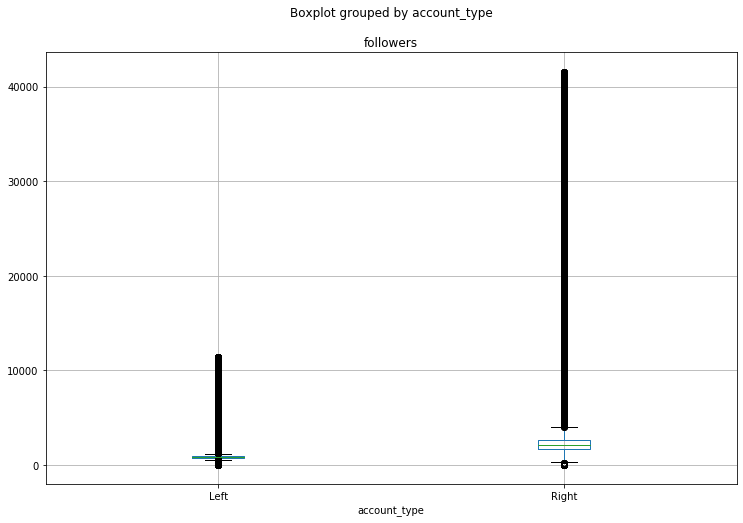

In [42]:
account_type_followers_filtered = filter_outliers_lr(account_type_followers, 'account_type', 'followers')
account_type_followers_filtered.boxplot('followers', by='account_type', figsize=(12, 8))

['n: 282422', 'n: 210357']


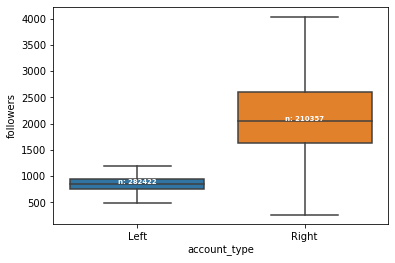

In [43]:
boxplot_withnum(account_type_followers_filtered,x='account_type',y='followers')

In [44]:
oneway_anova(account_type_followers_filtered, 'account_type', 'followers')

                    sum_sq        df             F  PR(>F)
account_type  7.901608e+11       1.0  39989.841441     0.0
Residual      9.736800e+12  492777.0           NaN     NaN


#### Analyze correlation between updates count and account_type (specifically Left or Right)

Continuing on, we want to determine whether or not Left or Right accounts tended to receive more "updates" (e.g., likes and retweets on their tweets). This is the first step in seeing if Russia was more successful in promoting rightist or leftist content.

We'll first start by extracting only the specific data we need into a new DataFrame.

In [45]:
left_right = tweets_2016_2017[(tweets_2016_2017['account_type']=='Left') | (tweets_2016_2017['account_type']=='Right')]
account_type_updates = left_right[['updates','account_type']]
account_type_updates.head()

,updates,account_type
publish_date,,
2017-01-23 22:36:00,9,Right
2017-01-23 22:37:00,10,Right
2017-01-23 22:40:00,11,Right
2016-10-12 11:41:00,1376,Left
2016-10-12 11:41:00,1371,Left


Now that we have this data, we want to once again boxplot it to give us some visual cues to whether or not one type or the other had a tendency to be more popular:

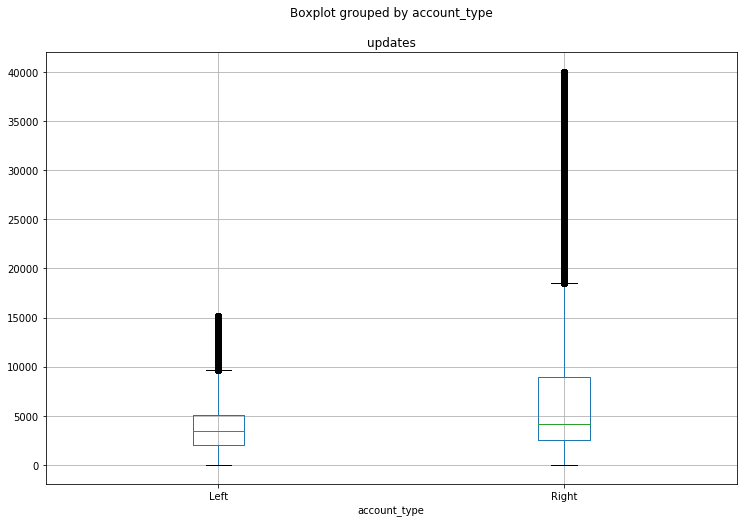

In [46]:
account_type_updates.boxplot('updates', by='account_type', figsize=(12, 8))

['n: 294376', 'n: 224462']


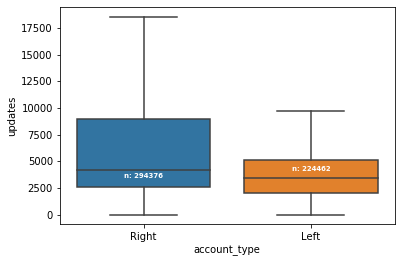

In [47]:
boxplot_withnum(account_type_updates,x='account_type',y='updates')

What was mildly surprising that we found here was that there actually didn't tend to be a more popular category. The large majority of Tweets on either side actually were almost about as equally popular as each other.

However, this information may be more for naut - on Twitter, it only takes individual tweets to go viral that really have an effect for manipulation. We can see that right leaning tweet outliers were successful in producing tweets that went massively viral, with over 150,000 updates. We will look into that with more detail in the following section.

Before that, however, we once again want to also run another ANOVA test to compare these two groups:

In [48]:
oneway_anova(account_type_updates, 'account_type', 'updates')

                    sum_sq        df             F  PR(>F)
account_type  2.352589e+12       1.0  60053.444972     0.0
Residual      2.032536e+13  518836.0           NaN     NaN


We can observe that there is a statistically significant difference between the groups according to the ANOVA. This is expected, because we observed extreme outliers within the "Right" group. We look into that with more detail now:

#### Analyze correlation between updates and account_type with outliers filtered

We want to filter down the tweets to just the ones considered "outliers". Once we do that, we will plot the data in a boxplot again.

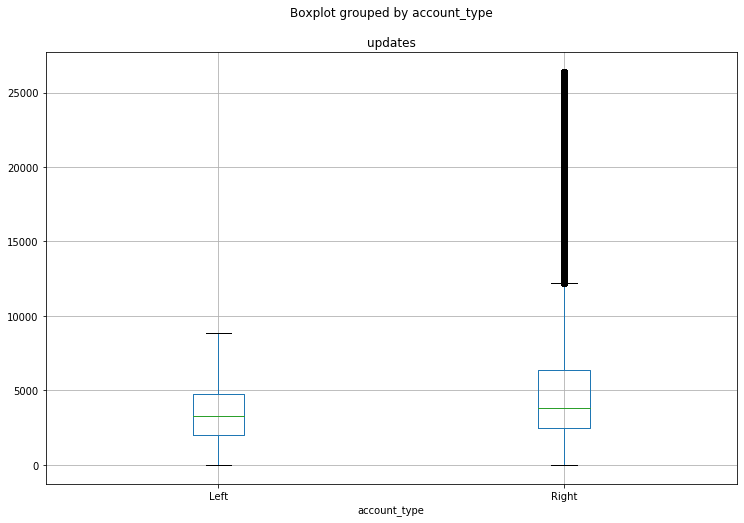

In [49]:
account_type_updates_filtered = filter_outliers_lr(account_type_updates, 'account_type', 'updates')
account_type_updates_filtered.boxplot('updates', by='account_type', figsize=(12, 8))

['n: 279430', 'n: 206803']


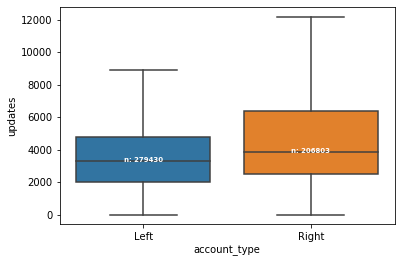

In [50]:
boxplot_withnum(account_type_updates_filtered,x='account_type',y='updates')

Within the outlier tweets, Leftist accounts generally stayed within a specific range. However, Rightest tweets had a greater range of updates, and even within these outlier tweets there were also strong outliers that received much more updates than ALL other tweets.

This suggests to us that Leftist tweets had a tendency to hit within a specific range, even the outliers, while Rightest tweets had much higher variance. Similarly however, this could still be considered a win for Russia's right leaning tweets - they had a higher number of tweets go massively viral, which can pass their message on effectively.

In [51]:
oneway_anova(account_type_updates_filtered, 'account_type', 'updates')

                    sum_sq        df             F  PR(>F)
account_type  8.411895e+11       1.0  48393.223889     0.0
Residual      8.451853e+12  486231.0           NaN     NaN


#### Analyze correlation between followers and tweet_type

Next up, we wanted to determine if the type of content Russian accounts propagated (whether they made new content, retweeted content, or quoted content) had any correlation between the number of followers those accounts had.

We'll be following the same approach as with the other sections, by plotting the results to a boxplot.

In [52]:
tweets_2016_2017['post_type'] = tweets_2016_2017['post_type'].str.lower()
tweets_2016_2017['post_type'].replace(np.nan, 'new', inplace=True)
tweet_type_followers = tweets_2016_2017[['followers','post_type']]

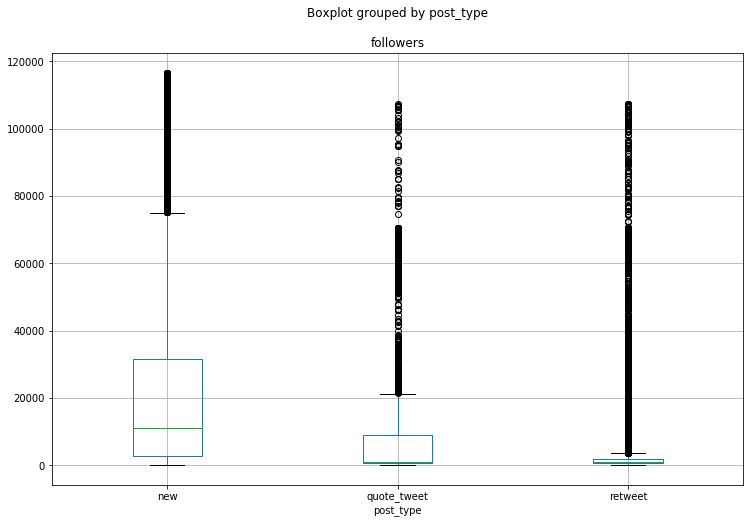

In [53]:
tweet_type_followers.boxplot('followers', by='post_type', figsize=(12, 8))

['n: 437990', 'n: 72665', 'n: 8183']


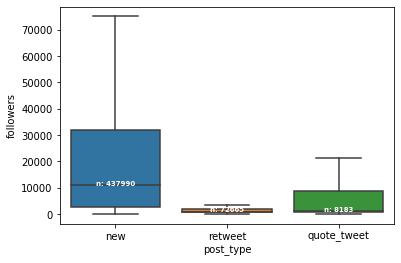

In [54]:
boxplot_withnum(tweet_type_followers,x='post_type',y='followers')

Immediately, we can observe that the accounts that tended to have more popular were overwhelmingly generating new content. The range between the lower and the upper quartile for accounts that posted more new tweets ranged between around low hundreds to 18,000, while the same quartiles for retweets and quotes both were around low hundreds to low thousands.

We will not perform an outlier analysis on this section because the data provided is slightly misleading - it is impossible for anything but new tweets to go viral, because they're the only new content. Retweets and quote tweets count back towards new content.

In [55]:
oneway_anova(tweet_type_followers, 'post_type', 'followers')

                 sum_sq        df              F  PR(>F)
post_type  2.326126e+13       2.0  116896.900365     0.0
Residual   5.162138e+13  518835.0            NaN     NaN


#### Analyze correlation between updates and tweet_types
Similar to the analysis above, we will try to find correlation between updates and tweet_types

In [56]:
tweet_type_updates = tweets_2016_2017[['updates','post_type']]

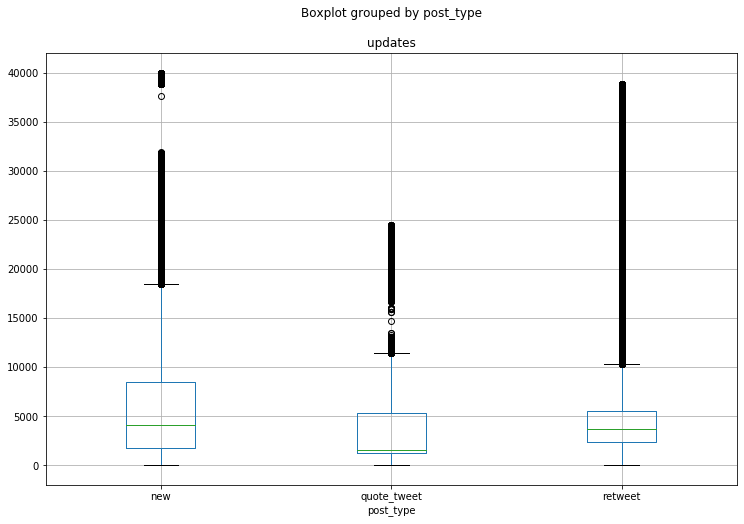

In [57]:
tweet_type_updates.boxplot('updates', by='post_type', figsize=(12, 8))

['n: 437990', 'n: 72665', 'n: 8183']


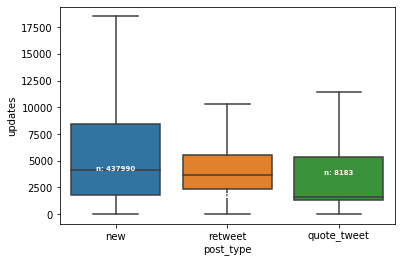

In [58]:
boxplot_withnum(tweet_type_updates,x='post_type',y='updates')

In [59]:
oneway_anova(tweet_type_updates, 'post_type', 'updates')

                 sum_sq        df            F  PR(>F)
post_type  4.561003e+11       2.0  5324.507846     0.0
Residual   2.222185e+13  518835.0          NaN     NaN


#### Analyze correlation between updates and tweet_types with outliers filtered

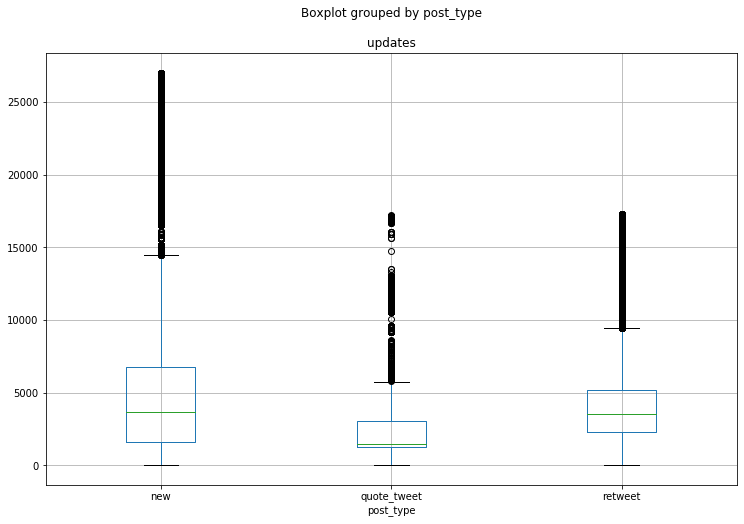

In [60]:
tweet_type_updates_filtered = filter_outliers_tweet_type(tweet_type_updates, 'updates')
tweet_type_updates_filtered.boxplot('updates', by='post_type', figsize=(12, 8))

['n: 414122', 'n: 66837', 'n: 7428']


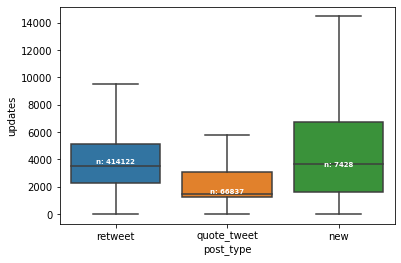

In [61]:
boxplot_withnum(tweet_type_updates_filtered,x='post_type',y='updates')

In [62]:
oneway_anova(tweet_type_updates_filtered, 'post_type', 'updates')

                 sum_sq        df            F  PR(>F)
post_type  2.121979e+11       2.0  8015.551876     0.0
Residual   6.464561e+12  488384.0          NaN     NaN


#### Analyze correlation between followers and tweet_length
Here we want to see if there is any correlation between number of followers for tweet and the length of the tweet. It is possible that if the tweet content is longer then the tweet will have more followers.

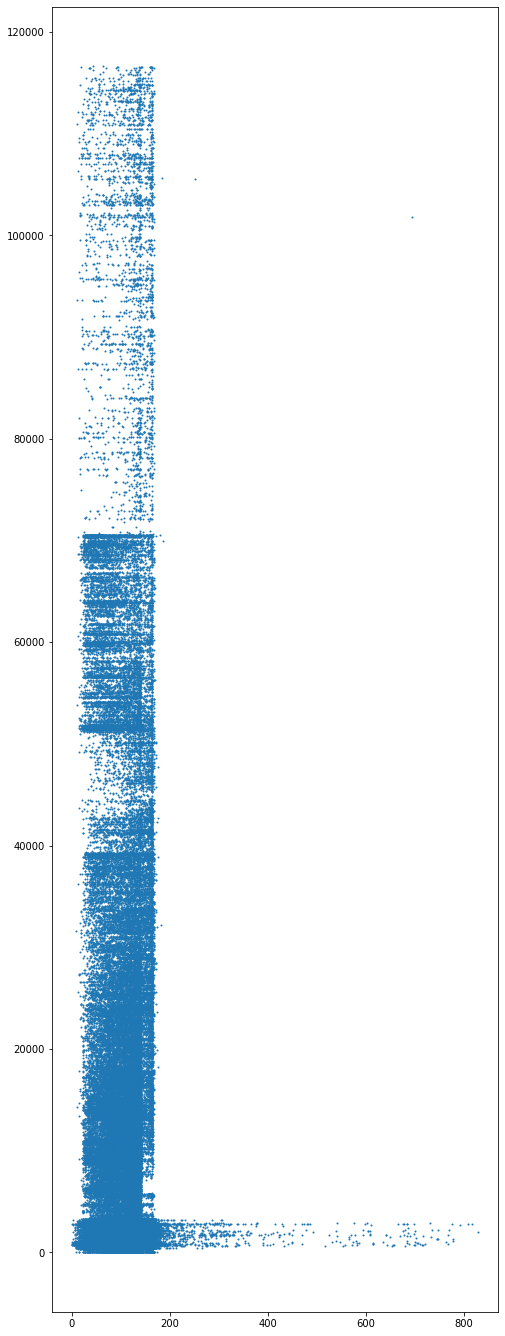

In [63]:
#plot followers against tweet length
tweets_2016_2017['tweet_length'] = tweets_2016_2017['content'].str.len()
fig, ax = plt.subplots(1,1,figsize=(8, 24))
ax.scatter(tweets_2016_2017['tweet_length'], tweets_2016_2017['followers'], s=1)

In [64]:
#compute relationship between tweet length and updates
outcome, predictors = patsy.dmatrices('followers ~ tweet_length', tweets_2016_2017)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              followers   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     968.8
Date:                Sat, 07 Dec 2019   Prob (F-statistic):          1.75e-212
Time:                        11:15:57   Log-Likelihood:            -5.6096e+06
No. Observations:              518838   AIC:                         1.122e+07
Df Residuals:                  518836   BIC:                         1.122e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6085.0844     54.040    112.602   

#### Analyze correlation between followers and tweet_length with popular words
Above, we have looked at the correlation between the 2 variables with all tweets that we are interested in.
Here, we want to narrow it down to some popular words and try to see if there is any correlation for tweets that contains those popular words.

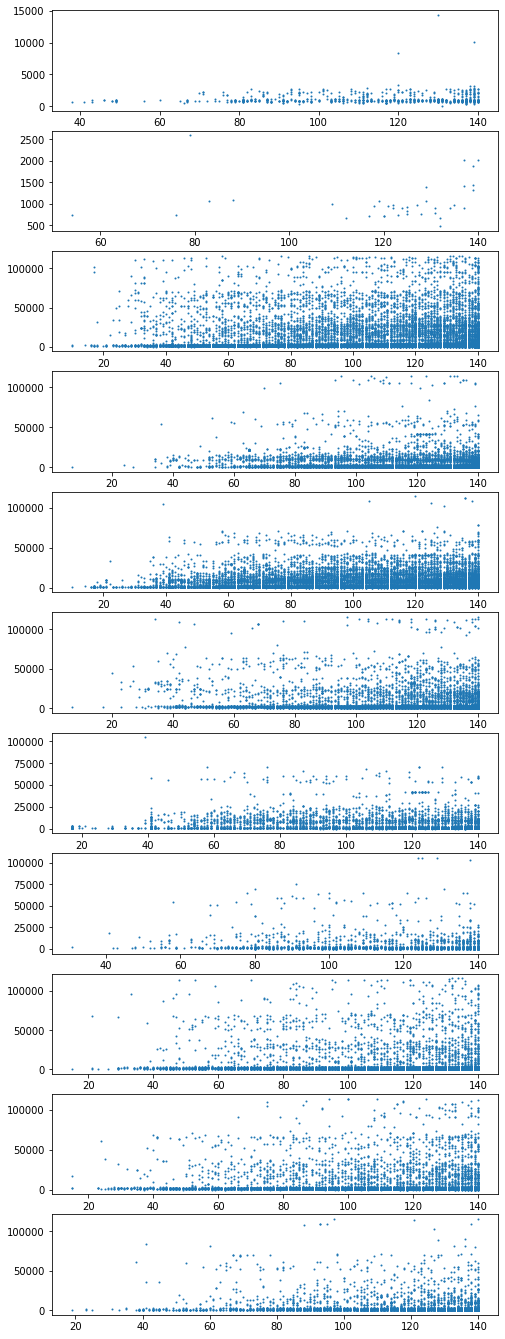

In [65]:
# Manually selected top popular words from the word frequency analysis part
top=['#news','#sports','trump','police','black','clinton','#blacklivesmatter','shooting','president','obama','woman']
fig, ax = plt.subplots(11,1,figsize=(8, 24))
for i,w in enumerate(top):
    subset = tweets_2016_2017[(tweets_2016_2017['content'].str.contains(w)) & (tweets_2016_2017['tweet_length']<=140)]
    ax[i].scatter(subset['tweet_length'], subset['followers'], s=1)

In [66]:
for i,w in enumerate(top):
    subset = tweets_2016_2017[(tweets_2016_2017['content'].str.contains(w)) & (tweets_2016_2017['tweet_length']<=140)]
    
    outcome, predictors = patsy.dmatrices('followers ~ tweet_length', subset)
    mod = sm.OLS(outcome, predictors)
    res = mod.fit()
    print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              followers   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     6.212
Date:                Sat, 07 Dec 2019   Prob (F-statistic):             0.0129
Time:                        11:16:04   Log-Likelihood:                -5640.4
No. Observations:                 688   AIC:                         1.128e+04
Df Residuals:                     686   BIC:                         1.129e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      772.4371    169.535      4.556   

                            OLS Regression Results                            
Dep. Variable:              followers   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     150.2
Date:                Sat, 07 Dec 2019   Prob (F-statistic):           2.35e-34
Time:                        11:16:06   Log-Likelihood:            -1.4304e+05
No. Observations:               13277   AIC:                         2.861e+05
Df Residuals:                   13275   BIC:                         2.861e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.142e+04    515.499     22.149   

                            OLS Regression Results                            
Dep. Variable:              followers   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     8.579
Date:                Sat, 07 Dec 2019   Prob (F-statistic):            0.00342
Time:                        11:16:08   Log-Likelihood:                -46505.
No. Observations:                4295   AIC:                         9.301e+04
Df Residuals:                    4293   BIC:                         9.303e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     8253.9809    938.875      8.791   

#### Analyze correlation between udpates and tweet_length
Similar to what we have done above, we want to see if there is any correlation between updates for each tweet and the length of the tweet content

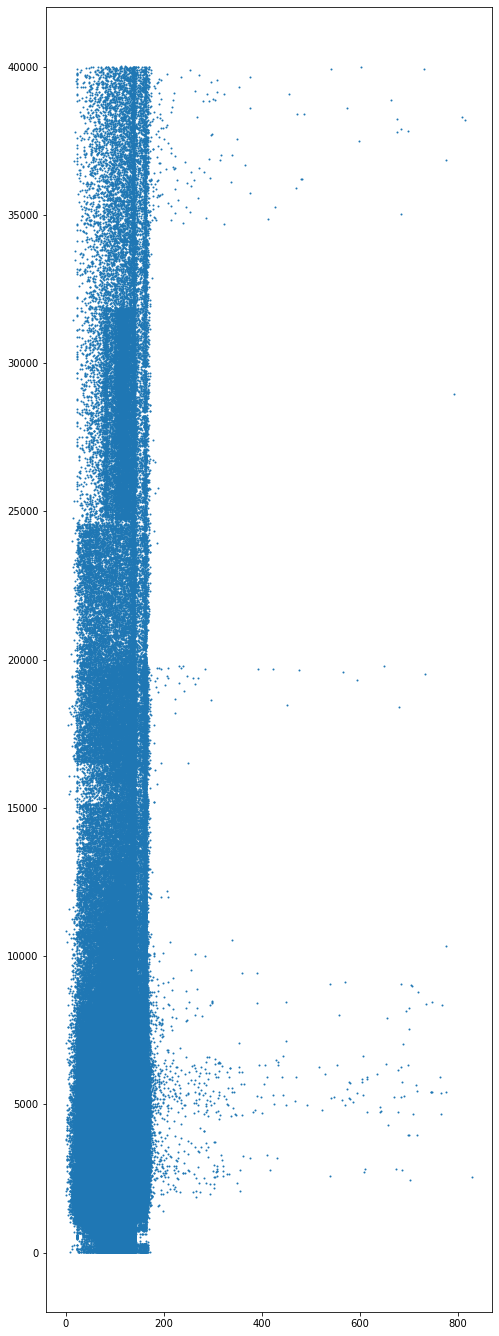

In [67]:
#plot followers against tweet length
tweets_2016_2017['tweet_length'] = tweets_2016_2017['content'].str.len()
fig, ax = plt.subplots(1,1,figsize=(8, 24))
ax.scatter(tweets_2016_2017['tweet_length'], tweets_2016_2017['updates'], s=1)


In [68]:
#compute relationship between tweet length and updates
outcome, predictors = patsy.dmatrices('updates ~ tweet_length', tweets_2016_2017)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                updates   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     738.1
Date:                Sat, 07 Dec 2019   Prob (F-statistic):          2.07e-162
Time:                        11:16:12   Log-Likelihood:            -5.2998e+06
No. Observations:              518838   AIC:                         1.060e+07
Df Residuals:                  518836   BIC:                         1.060e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5011.1076     29.746    168.464   

#### Analyze correlation between updates and tweet_length with popular words
Above, we have looked at the correlation between the 2 variables with all tweets that we are interested in.
Here, we want to narrow it down to some popular words and try to see if there is any correlation for tweets that contains those popular words.

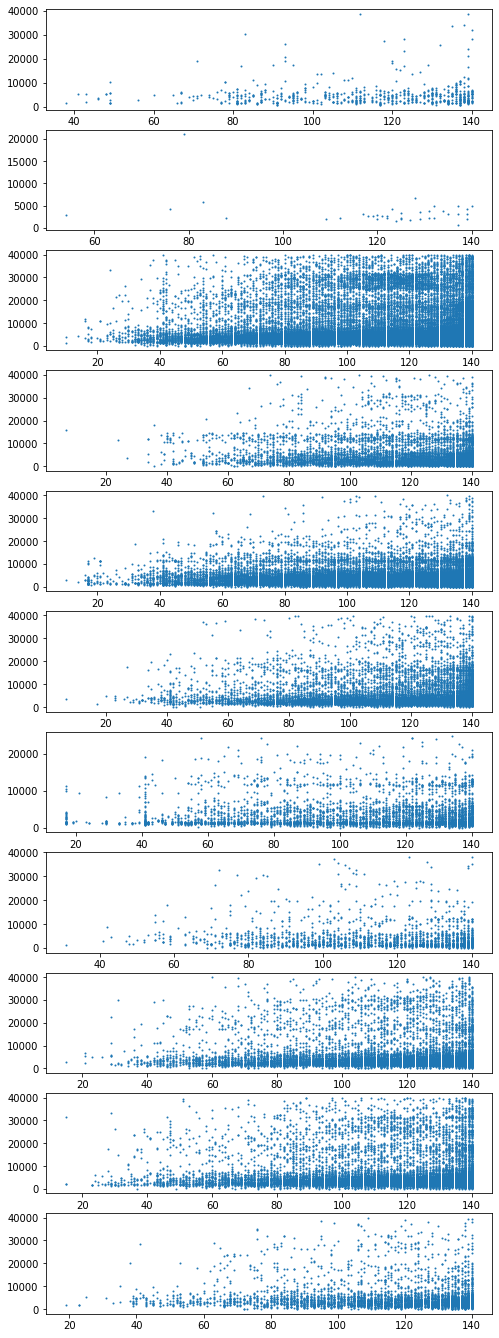

In [69]:
top=['#news','#sports','trump','police','black','clinton','#blacklivesmatter','shooting','president','obama','woman']
tweets_2016_2017['tweet_length'] = tweets_2016_2017['content'].str.len()
fig, ax = plt.subplots(11,1,figsize=(8, 24))
for i,w in enumerate(top):
    subset = tweets_2016_2017[(tweets_2016_2017['content'].str.contains(w)) & (tweets_2016_2017['tweet_length']<=140)]
    ax[i].scatter(subset['tweet_length'], subset['updates'], s=1)


In [70]:
for i,w in enumerate(top):
    subset = tweets_2016_2017[(tweets_2016_2017['content'].str.contains(w)) & (tweets_2016_2017['tweet_length']<=140)]
    
    outcome, predictors = patsy.dmatrices('updates ~ tweet_length', subset)
    mod = sm.OLS(outcome, predictors)
    res = mod.fit()
    print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                updates   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.802
Date:                Sat, 07 Dec 2019   Prob (F-statistic):             0.0946
Time:                        11:16:18   Log-Likelihood:                -6786.2
No. Observations:                 688   AIC:                         1.358e+04
Df Residuals:                     686   BIC:                         1.359e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3463.5228    896.449      3.864   

                            OLS Regression Results                            
Dep. Variable:                updates   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.351
Date:                Sat, 07 Dec 2019   Prob (F-statistic):              0.125
Time:                        11:16:20   Log-Likelihood:            -1.3407e+05
No. Observations:               13277   AIC:                         2.682e+05
Df Residuals:                   13275   BIC:                         2.682e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5552.8857    262.332     21.167   

                            OLS Regression Results                            
Dep. Variable:                updates   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.676
Date:                Sat, 07 Dec 2019   Prob (F-statistic):             0.0172
Time:                        11:16:23   Log-Likelihood:                -43441.
No. Observations:                4295   AIC:                         8.689e+04
Df Residuals:                    4293   BIC:                         8.690e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6353.3921    460.031     13.811   

# Privacy/Ethics Considerations

All of the tweets analyzed are sourced from fivethirtyeight.com. They were originally presented to Congress and subsequently released for public usage as a full disclosure for users of Twitter and consumers of popular news. In considering the ethicality of the topics discussed, these are public trending topics that are being discussed globally; moreover, on a personal level, these are topics that are important to be involved in and well informed on what is being implemented. 

The question we are asking in seeing what these bots are most likely to discuss does not bring up any ethical concerns, but rather attempts to recognize and identify the unethical use of publicly available technology. With the analysis of this data we aim to shed light on the realities of global propaganda and politics, as well as the power social media induces over public opinion.	


# Conclusion

Our Clear conclusion (answer to the question being asked) and discussion of results 
Limitations of analysis discussed 
Does not ramble on beyond providing necessary information 


# Predicting Political Leanings with NLP

## Introduction

Finally, with this data, and just for fun, we can train a linear classifier with SGD methods and teach it how to classify the political leanings of provided Tweets. For the purposes of this assignment, we will train a SGDClassifier to be able to differentiate between Left and Right leaning tweets only.

## Setup

We first install dependencies and import modules used to train our NLP model.

In [1]:
! pip install --user nltk

Now we import the dependencies we need for running NLP

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import collections
import numpy as np

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preparing Training Data

Because we will only be classifying between left or right political sides, we first will select only Left or Right leaning tweets (as classified by the 'account_type'). We'll also make sure of this with an assert.

In [5]:
# Use this box to test subsets of training data if necessary
#tweets_2016_2017 = pd.read_csv('./data/IRAhandle_tweets_1.csv')

In [6]:
tweets_2016_2017_lr = tweets_2016_2017[(tweets_2016_2017['account_type']=='Left') | (tweets_2016_2017['account_type']=='Right')]

In [7]:
# A quick way for us to make sure to some light degree our data is properly cleaned
assert(sorted(set(tweets_2016_2017_lr['account_type'])) == ["Left", "Right"])

## Label Matrix Representations

In our matrix, we need to assign values to our groups. We assign 0.0 for "Right" and 1.0 for "Left" account_types"

In [8]:
def convert_label(label):
    if label == "Right": return 0.0
    elif label == "Left": return 1.0
    else: return label

For future use, we also want to define a function that does it the other way around

In [9]:
def convert_number(num):
    if num == 0.0: return "Right"
    elif num == 1.0: return "Left"
    else: return num

And then now, we use the convert_label() function and apply it to our english_tweets dataframe.

In [10]:
tweets_2016_2017_lr['y'] = tweets_2016_2017_lr['account_type'].apply(convert_label)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
# Once again, make sure we're doing things right - this is useful for quick validations
assert(sorted(set(tweets_2016_2017_lr['y'])) == [0., 1.])

## Vectorizing Our Data

We will vectorize our data using the TF-IDF method. Our SGDClassifier will be trained using these vectors. 

A hardware limitation we encountered was that our hardware devices aren't really capable of transforming more than about 20,000 tweets at any given time. Thus, we will batch-train the SGDClassifier by using 2000 TF-IDF fit-transformed data which uses random samples of size 20,000.

In [12]:
# Create our SVC that we will batch-train
clf = SGDClassifier()

In [13]:
# Create the TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer="word", 
                             tokenizer=word_tokenize, 
                             stop_words=stopwords.words('english'))

# Training the SGDClassifier

### Fitting the Data
Batch-train the SGDClassifier with `partial_fit()` by passing in 2,000 random samples from our Tweets.

In [14]:
for i in range(2000):
    # Train using sample sizes of 20,000
    data = tweets_2016_2017_lr.sample(20000)
    et_x = vectorizer.fit_transform(data['content']).toarray()
    et_y = data['y']
    # Once we have this sample data transformed and fitted into the vectorizer, train CLF with it
    # Note: vectorizer.fit_transform() will change [vocab] shape each time cause fit_transform(), this is okay
    clf.partial_fit(et_x, et_y, classes=np.unique(et_y))

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### How Accurate Are We?

We fetch a random sample of 20,000 tweets (doesn't have to be 20,000), and run an analysis on how accurate the SGDClassifier is:

In [15]:
# Let's see how accurate (or inaccurate this is)

test_data = tweets_2016_2017_lr.sample(20000)
test_data_vector = vectorizer.transform(test_data['content']).toarray()
test_data_y = test_data['y']

results = clf.predict(test_data_vector)
print(classification_report(test_data_y, results))

              precision    recall  f1-score   support

         0.0       0.86      0.95      0.91     15122
         1.0       0.79      0.52      0.63      4878

    accuracy                           0.85     20000
   macro avg       0.82      0.74      0.77     20000
weighted avg       0.84      0.85      0.84     20000



### Testing Your Own Sentence

We define a function that allows anyone to test their own input sentence

In [23]:
def find_leaning(content):
    vectorized = vectorizer.transform(pd.Series([content])).toarray()
    result = clf.predict(vectorized)
    return convert_number(result[0])

You can use this method in any box below. Have it in the form of:

```python3
find_leaning("whatever you want to try")
```

For example:

In [26]:
find_leaning("Black lives matter!")

'Left'

## 4. Privacy/Ethics Considerations

With regards to the data we used, we do not believe there are any private/ethical considerations to be made. The Tweet data does not belong to individuals, but a coordinated bot network used in a misinformation campaign. Furthermore, this data was declassified and released into the public domain by the owner of the data, so we believe it is perfectly okay to use this data for standard research.

One minor ethical concern that we raised with this data is that the tweets deal largely with content that is extremely polarizing. While we did not focus strongly on the actual tweet *content* - as opposed to quantative variables associated with the tweets -, we need to consider that the Tweets themselves could contain questionable or triggering content.

Finally, a minor concern is that we will never be fully confident if the information we have is truly a representative sample of all of Russian tweet data that exists on Twitter. It is extremely hard to identify this kind of behavior, which we can attest to at a personal level - two of the members in our group have been employed by a company whose platform was also used in mass misinformation campaigns -, so we are not fully confident our sample data only has standard sampling error, as opposed to completely misrepresenting a much larger picture.

In [ ]:
#